In this tutorial, we're going to study the K2-24 system, composed of two planets near 2:1 resonance (Petigura et al. 2018). This is an important example because K2 observations will sparsely sample the super-period, likely leading to multimodalities in the posteriors. 

First, we'll set everything up and import ttvnest:

In [1]:
%matplotlib inline
import numpy as np
import ttvnest
import scipy
import time
import multiprocess
from ttvnest.constants import *

Now, let's download the data for Kepler-29 (KOI-738) from the Holczer et al. (2016) catalog:

In [2]:
nplanets = 2
filename = 'k2_24_spitzer.dat'
data, errs = ttvnest.load_data.get_data_from_file(nplanets, filename)

Reading data from file...
Data retrieved!


Next, we need to define the prior transform. Nested sampling methods typically sample on the unit cube (from 0 to 1 in all dimensions), so we need a way to map that into our preferred prior space. Eventually, I'll try to abstract the prior transform away from the user.

In [3]:
#defining the prior transform

def prior_transform(u):
	x = np.array(u) #copy u
	#planet 1
	x[0] = 40.*u[0] #uniform on [0, 40) earth masses
	x[1] = scipy.stats.norm.ppf(u[1], 20.88, 0.01)  #gaussian around 10.33585 with a width of 0.01
	x[2] = scipy.stats.norm.ppf(u[2], 0, 0.1) #gaussian around 0 with a width of 0.1
	x[3] = scipy.stats.norm.ppf(u[3], 0, 0.1) #gaussian around 0 with a width of 0.1
	x[4] = (u[4] % 1.) * 360. #periodic on [0, 360) degrees
	#planet 2
	x[5] = 40.*u[5] #uniform on [0, 40) earth masses
	x[6] = scipy.stats.norm.ppf(u[6], 42.34, 0.01) #gaussian around 13.29292 with a width of 0.01
	x[7] = scipy.stats.norm.ppf(u[7], 0, 0.1) #gaussian around 0 with a width of 0.1
	x[8] = scipy.stats.norm.ppf(u[8], 0, 0.1) #gaussian around 0 with a width of 0.1
	x[9] = (u[9] % 1.) * 360. #periodic on [0, 360) degrees
	return x

Finally, we sample the posteriors!

In [7]:
poolsize = multiprocess.cpu_count() - 1
with multiprocess.Pool(poolsize) as executor:
    %time results = ttvnest.retrieval.retrieve(nplanets, prior_transform, data, errs, \
                                               pool = executor, queue_size = poolsize, \
                                               start_time = tkep + 2000, sim_length = 700,\
                                               init_live = 5000)

Running dynesty with the rwalk sampler, multi bounding, and 5000 initial live points...


iter: 68539 | batch: 0 | bound: 91 | nc: 25 | ncall: 1474325 | eff(%):  4.633 | loglstar:   -inf < -24179.403 <    inf | logz: -24201.904 +/-  0.093 | dlogz: 22367.430 >  0.010                      /usr/local/lib/python3.7/site-packages/dynesty/sampling.py:237: UserWarning: Random walk proposals appear to be extremely inefficient. Adjusting the scale-factor accordingly.
  warnings.warn("Random walk proposals appear to be "
iter: 71734 | batch: 0 | bound: 97 | nc: 25 | ncall: 1561721 | eff(%):  4.579 | loglstar:   -inf < -18163.941 <    inf | logz: -18186.895 +/-  0.094 | dlogz: 16771.362 >  0.010                      /usr/local/lib/python3.7/site-packages/dynesty/sampling.py:237: UserWarning: Random walk proposals appear to be extremely inefficient. Adjusting the scale-factor accordingly.
  warnings.warn("Random walk proposals appear to be "
iter: 72315 | batch: 0 | bound: 98 | nc: 25 | ncall: 1579596 | eff(%):  4.564 | loglstar:   -inf < -17225.861 <    inf | logz: -17248.561 +/-  0.0

CPU times: user 45min 21s, sys: 7min 15s, total: 52min 37s
Wall time: 1d 6h 6min 57s


In [8]:
#%time results = ttvnest.retrieval.retrieve(nplanets, prior_transform, data, errs, start_time = tkep + 2000, sim_length = 200)

Let's now see a summary of our results:

In [9]:
ttvnest.retrieval.posterior_summary(results)

Summary: 
$M_1/M_\star$: $11.286560703645344^{+16.43818414791192}_{-1.3640879019949192}$
$P_1\ [\mathrm{days}]$: $20.88416843855757^{+0.003122445572611099}_{-0.0008046304634810042}$
$e_1\cos(\omega_1)$: $-0.03521938247272722^{+0.07035837528690912}_{-0.012267848658707114}$
$e_1\sin(\omega_1)$: $-0.14483720774854236^{+0.2669166379492701}_{-0.03814542260062276}$
$\mathcal{M}_1\ [^\circ]$: $100.55852923936433^{+175.2628181090184}_{-6.133056684748311}$
$M_2/M_\star$: $8.62179915765499^{+12.873074094784961}_{-1.109887661082328}$
$P_2\ [\mathrm{days}]$: $42.3700759533293^{+0.002155091885612137}_{-0.009548992862818295}$
$e_2\cos(\omega_2)$: $0.1202194584604619^{+0.047262147175381006}_{-0.21125371874216609}$
$e_2\sin(\omega_2)$: $-0.0690617217669596^{+0.023317943458592567}_{-0.12832937209988746}$
$\mathcal{M}_2\ [^\circ]$: $331.69660034331366^{+13.809249790096146}_{-233.8631202723205}$


And let's plot the result, as well as the corner plot, a summary of the run, and the dynesty trace plot.

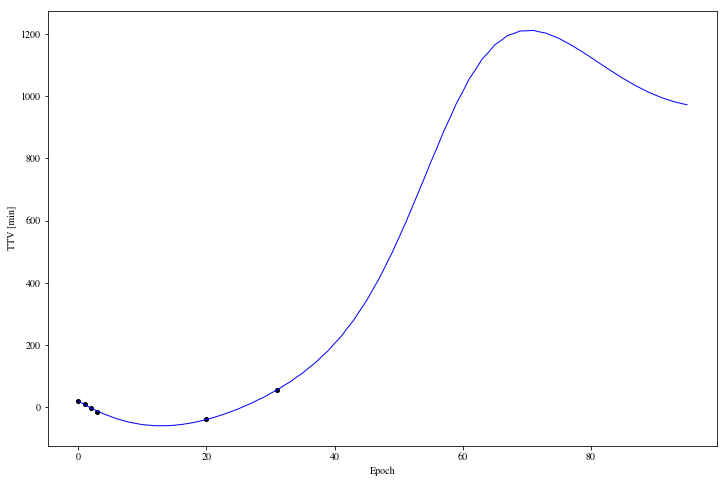

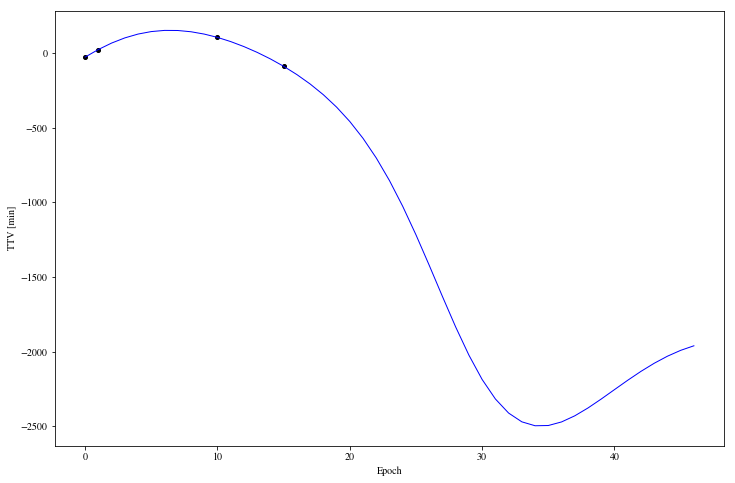

<Figure size 1440x1440 with 0 Axes>

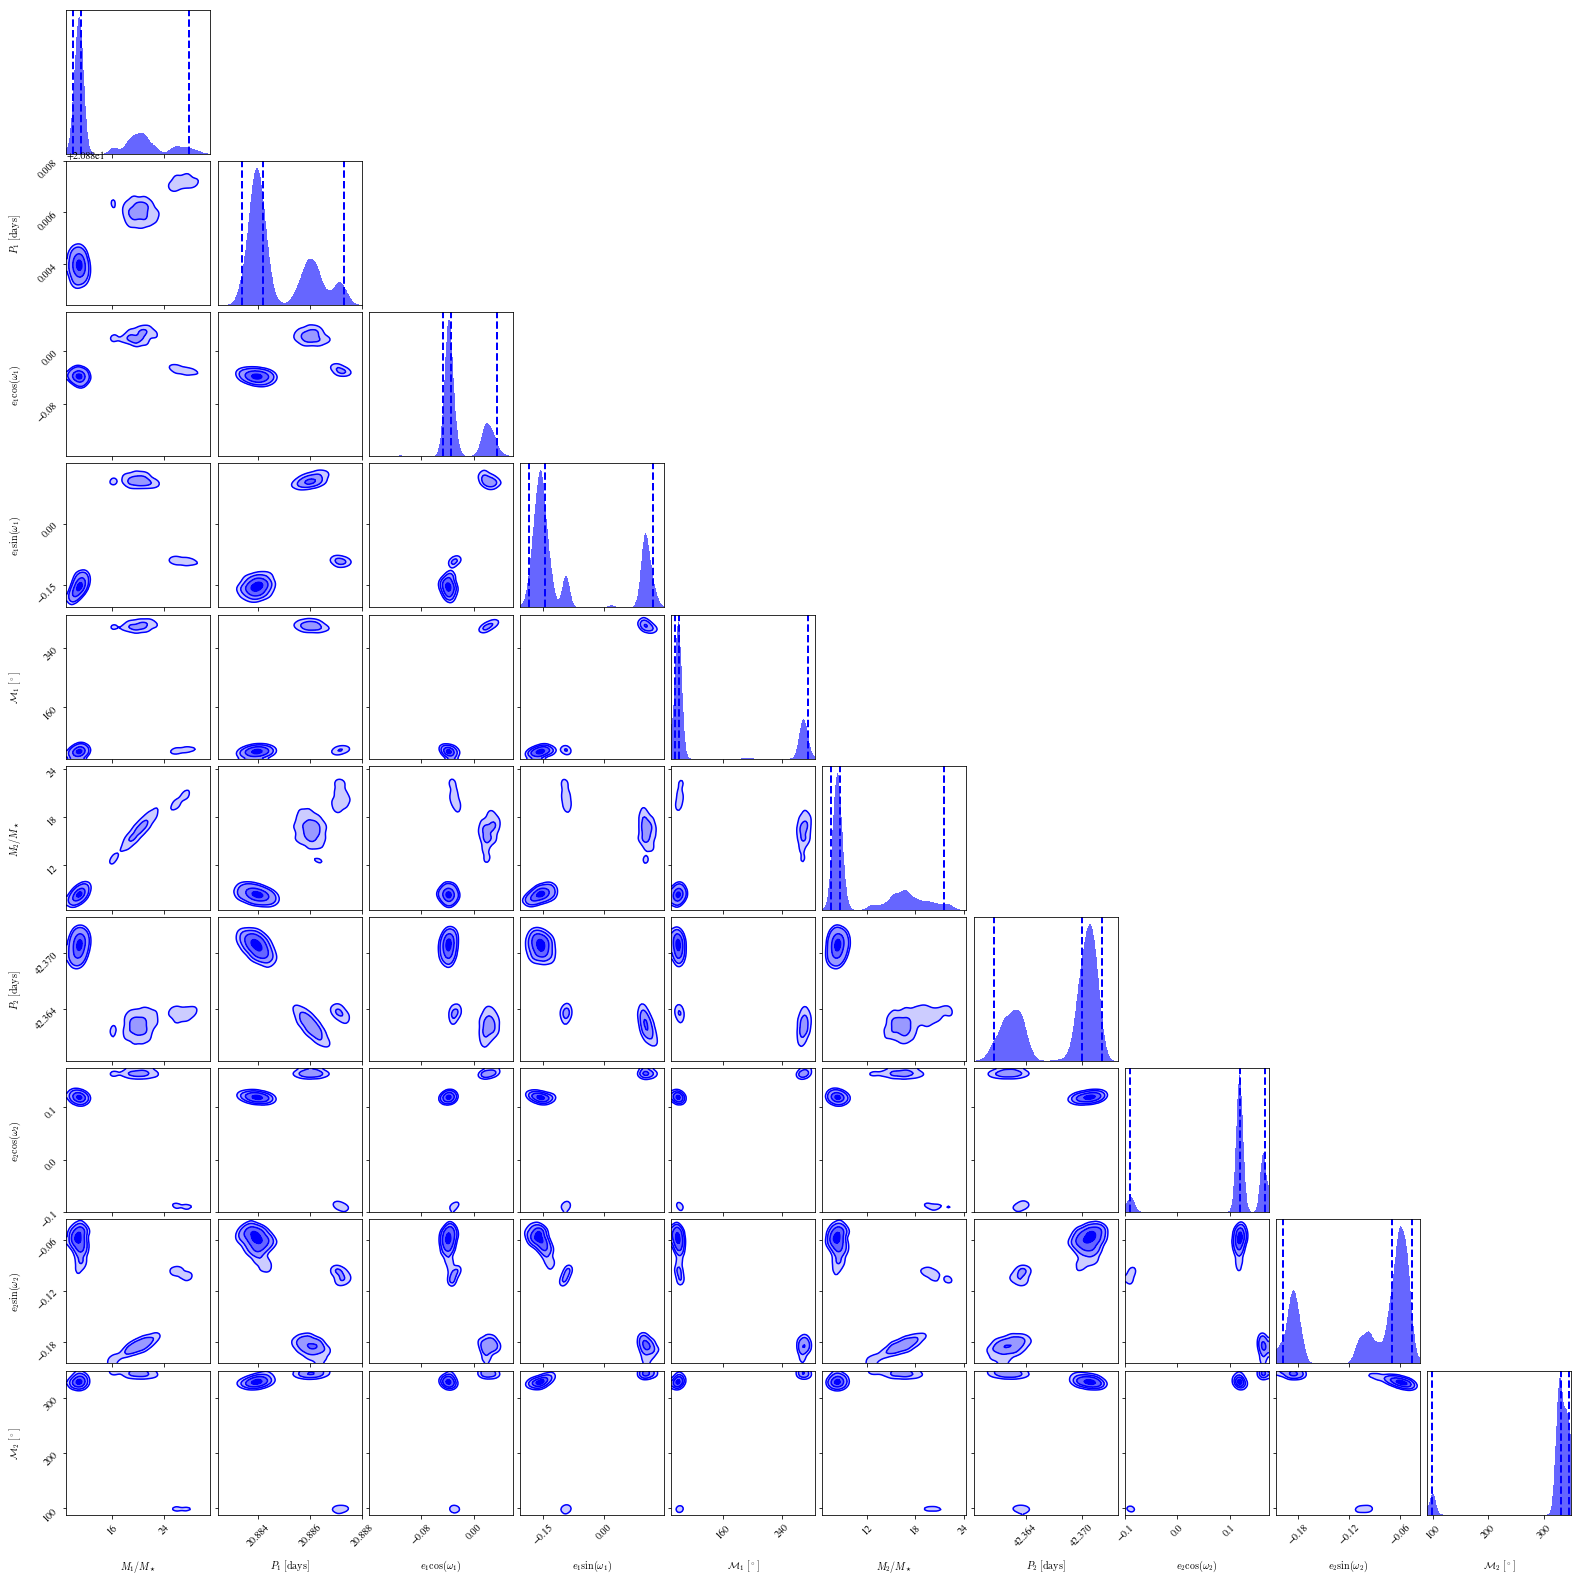

<Figure size 1440x1440 with 0 Axes>

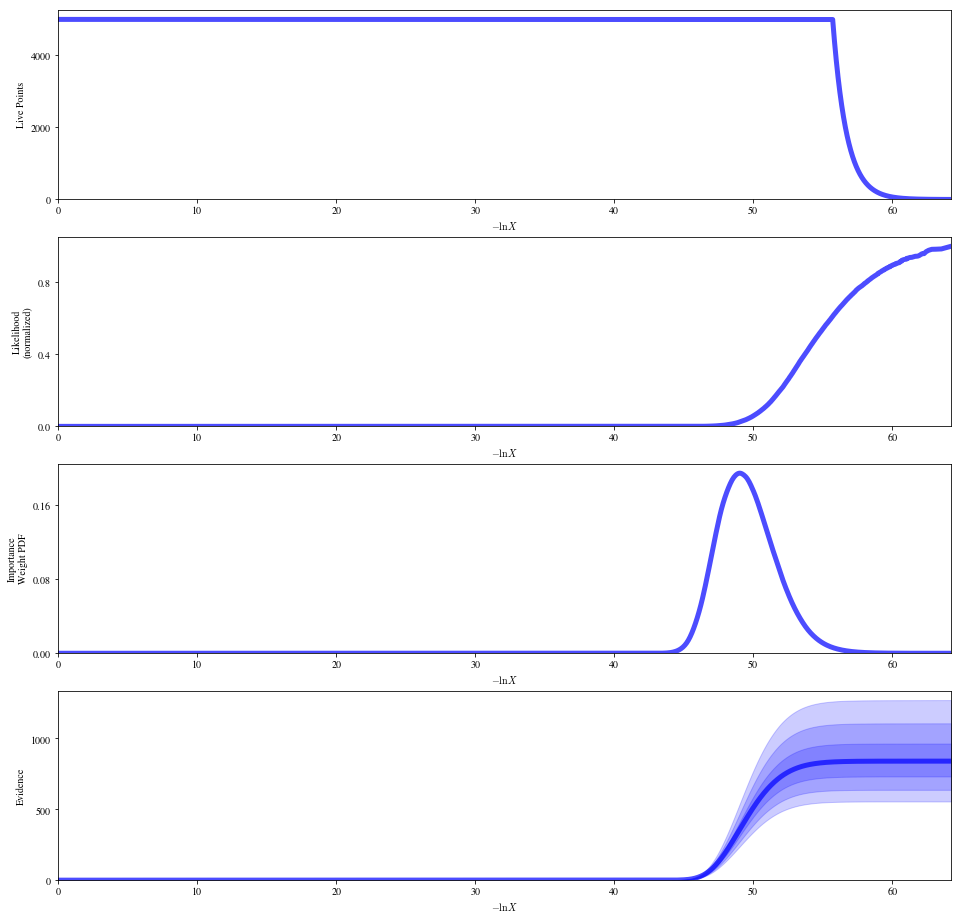

<Figure size 1440x1440 with 0 Axes>

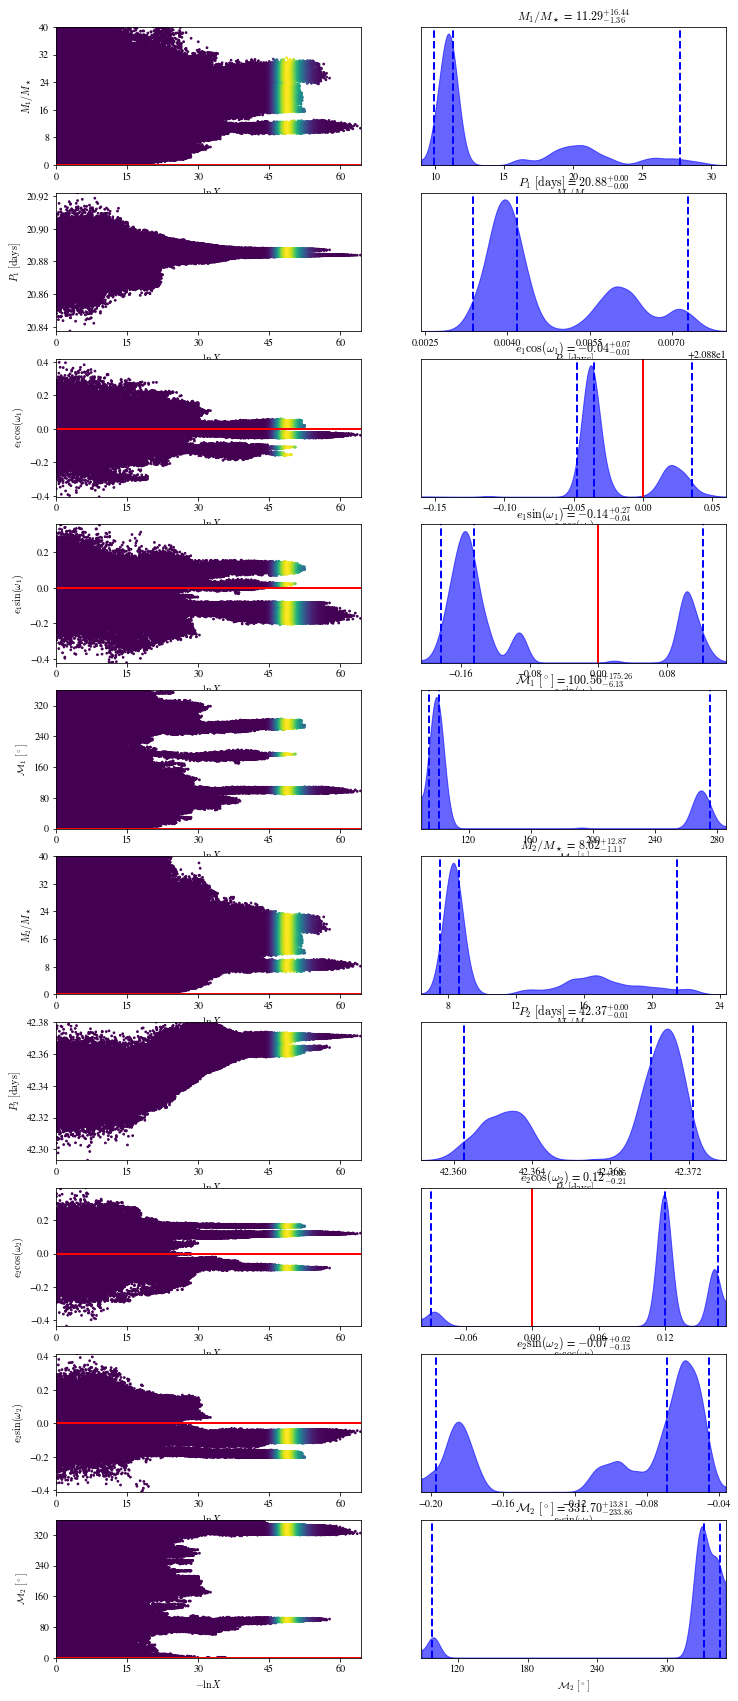

In [10]:
ttvnest.plot_utils.plot_results(results, data, errs, start_time = tkep + 2000)
ttvnest.plot_utils.dynesty_plots(results, nplanets)

Let's make sure to save our results! The results will be saved in a file called 'results.p' by default, but you can change that with the "outname" keyword for save_results.

In [11]:
ttvnest.io_utils.save_results(results, outname = 'results_k2_24_spitzer.p')

'results_k2_24_spitzer.p'